In [1]:
import os
import pandas as pd
import actr
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import natsort

ACT-R connection has been started.


In [2]:
class MiniModel:
    def __init__(self, num_productions=10, param_set=None):
        self.curr_index = 0
        self.curr_onset = 0
        self.curr_offset = 0
        self.curr_production = ""
        self.ordered_productions = ["P"+str(i+1) for i in range(num_productions)]
        self.production_at = np.arange(1, num_productions+1)/100
        self.production_reward = range(num_productions)
        
        self.trial_trace = []
        self.production_trace = []
        self.reward_trace = []
        self.utility_trace = []
        
        self.param_set = param_set
    
    def setup_model(self, model="mini-model.lisp", retrieve=False):
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        actr.load_act_r_model(os.path.join(curr_dir, model))
        if retrieve:
            actr.pdisable('skip-retrieval')
        else:
            actr.pdisable('retrieve-rule')
        self.setup_parameters()
    
    def cost_function(self, x, c=1.5, enable=True):
        c = np.exp(x*c)-1
        if enable:
            return np.round(c, 4)
        else:
            return x

    def payoff_function(SELF, x, l=10, k=1, x0=5, enable=True):
        """
        sigmoid function
            x0 = mid point
            l = max 
            k = slope
        """
        r = l / (1 + np.exp(-k * ( x - x0)))
        if enable:
            return np.round(r, 4)
        else: 
            return x
        
    def setup_parameters(self):
        actr.hide_output()
        # set at parameter
        
        # set difficulty level
        x0 = 5
        if self.param_set and 'difficulty' in self.param_set.keys():
            #print('set difficulty level')
            x0 = self.param_set['difficulty']

        self.production_at = [self.cost_function(x) for x in self.production_at]
        self.production_reward = [self.payoff_function(x, x0=x0) for x in self.production_reward]
        
        for i in range(len(self.ordered_productions)):
            actr.spp(self.ordered_productions[i], ":at", self.production_at[i], ":reward", self.production_reward[i])
        #actr.spp("DONE", ":reward", 1)
        actr.unhide_output() 
        

    def production_hook(self, *params):
        #print('in p hook', params)
        production = params[0]
        if production == "START-TRIAL":
            self.curr_index += 1
            self.curr_onset = actr.mp_time()
        elif production == "DONE":
            self.curr_offset = actr.mp_time()
            self.trial_trace.append((self.curr_index, self.curr_production, np.round(self.curr_offset-self.curr_onset, 2)))
            #print(self.curr_index, self.curr_onset, self.curr_offset, self.curr_offset-self.curr_onset)
        elif production in self.ordered_productions:
            self.production_trace.append((self.curr_index, production, actr.mp_time()))
            self.curr_production = production
        return production
    
    def reward_hook(self, *params):
        production = params[0]
        delivered_reward = params[1]
        discounted_reward = params[2]
        if production in self.ordered_productions:
            #print('in reward hook', production)
            self.reward_trace.append((self.curr_index, production, actr.mp_time(), delivered_reward, discounted_reward))
        return (params)

    def utility_hook(self, *params):
        #print('u', len(params), params)
        # NEW: record the production utility
        #self.current_trial.utility_trace=[self.extract_production_parameter('PROCESS-SHAPE', ':u'),
        #                                     self.extract_production_parameter('PROCESS-LOCATION', ':u'),
        #                                     self.extract_production_parameter('DONT-PROCESS-SHAPE', ':u'),
        #                                     self.extract_production_parameter('DONT-PROCESS-LOCATION', ':u')]
        #print(self.extract_production_parameter('P1', ':u'))
        pass
          
    def extract_production_parameter(self, epoch):
        """
        This function will extract the parameter value of a production during model running
        """
        #assert (production_name in actr.all_productions() and
        #        parameter_name in [':u', ':utility', ':at', ':reward', ':fixed-utility'])
        utility_trace = []
        actr.hide_output()
        for production_name in self.ordered_productions:
            u = actr.spp(production_name, ":u")[0][0]
            utility = actr.spp(production_name, ":utility")[0][0]
            reward = actr.spp(production_name, ":reward")[0][0]
            utility_trace.append((epoch, production_name, u, utility, reward))
        actr.unhide_output()
        return pd.DataFrame(utility_trace, columns=['epoch','production', 'u', 'utility', 'delivered_reward'])
    
    def df_trace_output(self):
        df_trial_trace = pd.DataFrame(self.trial_trace, columns=['trial', 'production', 'response_time'])
        df_production_trace = pd.DataFrame(self.production_trace, columns=['trial', 'production', 'firing_time'])
        df_reward_trace = pd.DataFrame(self.reward_trace, columns=['trial', 'production', 'rewarded_time', 'delivered_reward', 'passed_time'])
        df_reward_trace['received_reward'] = df_reward_trace['delivered_reward']-df_reward_trace['passed_time']
        df_cost = pd.DataFrame(list(zip(self.ordered_productions, self.production_at)), columns=["production", "at"])
        df_utility_trace = pd.merge(self.utility_trace, df_cost)
        return pd.merge(pd.merge(pd.merge(df_trial_trace, df_production_trace, on=['trial', 'production']),df_reward_trace, on=['trial', 'production']), df_utility_trace, on=["production", "delivered_reward"]).drop_duplicates()
        #return (df_trial_trace, df_production_trace, df_reward_trace, df_utility_trace)
        
    def experiment(self, time=100):
        actr.add_command("production-hook",self.production_hook)
        actr.add_command("reward-hook", self.reward_hook)
        actr.add_command("utility-hook", self.utility_hook)
        actr.schedule_event_relative(0.01, "production-hook")
        actr.schedule_event_relative(0.01, "reward-hook")
        actr.schedule_event_relative(0.01, "utility-hook")

        self.setup_model()
        actr.run(time)
        actr.remove_command("production-hook")
        actr.remove_command("reward-hook")
        actr.remove_command("utility-hook")

def simulation(epoch=1, time=100, param_set=None):
    simulated_results = []
    for i in range(epoch):
        if i%(epoch/10) == 0: 
            print("==== SIMULATED ==== epoch >>", i)
            print("PARAMETERS: ", param_set)
        m = MiniModel(param_set=param_set)
        m.experiment(time=time)
        
        # record utility
        m.utility_trace = m.extract_production_parameter(i)
        simulated_results.append(m)
    return simulated_results

## Simulate Model

Task difficulty = LOW

In [3]:
epoch = 100

In [4]:
simulated_results_low = simulation(epoch=epoch, time=10, param_set={'difficulty':3})

==== SIMULATED ==== epoch >> 0
PARAMETERS:  {'difficulty': 3}
==== SIMULATED ==== epoch >> 10
PARAMETERS:  {'difficulty': 3}
==== SIMULATED ==== epoch >> 20
PARAMETERS:  {'difficulty': 3}
==== SIMULATED ==== epoch >> 30
PARAMETERS:  {'difficulty': 3}
==== SIMULATED ==== epoch >> 40
PARAMETERS:  {'difficulty': 3}
==== SIMULATED ==== epoch >> 50
PARAMETERS:  {'difficulty': 3}
==== SIMULATED ==== epoch >> 60
PARAMETERS:  {'difficulty': 3}
==== SIMULATED ==== epoch >> 70
PARAMETERS:  {'difficulty': 3}
==== SIMULATED ==== epoch >> 80
PARAMETERS:  {'difficulty': 3}
==== SIMULATED ==== epoch >> 90
PARAMETERS:  {'difficulty': 3}


In [5]:
simulated_results_medium = simulation(epoch=epoch, time=10, param_set={'difficulty':5})

==== SIMULATED ==== epoch >> 0
PARAMETERS:  {'difficulty': 5}
==== SIMULATED ==== epoch >> 10
PARAMETERS:  {'difficulty': 5}
==== SIMULATED ==== epoch >> 20
PARAMETERS:  {'difficulty': 5}
==== SIMULATED ==== epoch >> 30
PARAMETERS:  {'difficulty': 5}
==== SIMULATED ==== epoch >> 40
PARAMETERS:  {'difficulty': 5}
==== SIMULATED ==== epoch >> 50
PARAMETERS:  {'difficulty': 5}
==== SIMULATED ==== epoch >> 60
PARAMETERS:  {'difficulty': 5}
==== SIMULATED ==== epoch >> 70
PARAMETERS:  {'difficulty': 5}
==== SIMULATED ==== epoch >> 80
PARAMETERS:  {'difficulty': 5}
==== SIMULATED ==== epoch >> 90
PARAMETERS:  {'difficulty': 5}


In [6]:
simulated_results_high = simulation(epoch=epoch, time=10, param_set={'difficulty':7})

==== SIMULATED ==== epoch >> 0
PARAMETERS:  {'difficulty': 7}
==== SIMULATED ==== epoch >> 10
PARAMETERS:  {'difficulty': 7}
==== SIMULATED ==== epoch >> 20
PARAMETERS:  {'difficulty': 7}
==== SIMULATED ==== epoch >> 30
PARAMETERS:  {'difficulty': 7}
==== SIMULATED ==== epoch >> 40
PARAMETERS:  {'difficulty': 7}
==== SIMULATED ==== epoch >> 50
PARAMETERS:  {'difficulty': 7}
==== SIMULATED ==== epoch >> 60
PARAMETERS:  {'difficulty': 7}
==== SIMULATED ==== epoch >> 70
PARAMETERS:  {'difficulty': 7}
==== SIMULATED ==== epoch >> 80
PARAMETERS:  {'difficulty': 7}
==== SIMULATED ==== epoch >> 90
PARAMETERS:  {'difficulty': 7}


## Clean Data 

In [7]:
def merge_simulation_data(results):
    n = len(results)
    dfs = [results[i].df_trace_output() for i in range(n)]
    df = pd.concat(dfs, axis=0)
    
    # shift column 'epoch' to first position
    first_column = df.pop('epoch')
    df.insert(0, 'epoch', first_column)
    df.sort_values(['epoch', 'trial'], inplace=True)
    return df

In [8]:
df1 = merge_simulation_data(simulated_results_low)
df2 = merge_simulation_data(simulated_results_medium)
df3 = merge_simulation_data(simulated_results_high)

## Visualize Data

In [9]:
def plot_actr_evc1(df, subtitle=""):
    """seperate plot"""
    order=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]
    fig, ax = plt.subplots(1,4, figsize=(15,4))
    fig.suptitle("Simulation results: N = {}, {}".format(len(df), subtitle))
    sns.pointplot(x="production", y="at", order=order, data=df, palette="Greens", ax=ax[0]).set_title('Cost of Productions')
    sns.pointplot(x="production", y="received_reward", data=df, order=order, palette="Reds", ax=ax[1]).set_title('Reward of Productions')
    sns.countplot(x=df['production'], order=order, palette="Purples", ax=ax[2]).set_title('Distribution of Productions')
    sns.lineplot(x="production", y="u", color="purple", data=df.iloc[natsort.index_humansorted(df.production)], ax=ax[3]).set_title('Utility of Productions')
    plt.show()
    
def plot_actr_evc2(df, subtitle=""):
    """in single plots"""
    order=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    ax4 = ax.twinx()
    sns.countplot(x=df['production'], order=order, palette="Purples", ax=ax).set_title('EVC in ACT-R: {}'.format(subtitle))
    sns.pointplot(x="production", y="received_reward", data=df, order=order, palette="Reds", ax=ax2)
    sns.pointplot(x="production", y="response_time", order=order, data=df, palette="Blues", ax=ax3)
    sns.lineplot(x="production", y="u", color="purple", data=df.iloc[natsort.index_humansorted(df.production)], ax=ax4)
    plt.show()

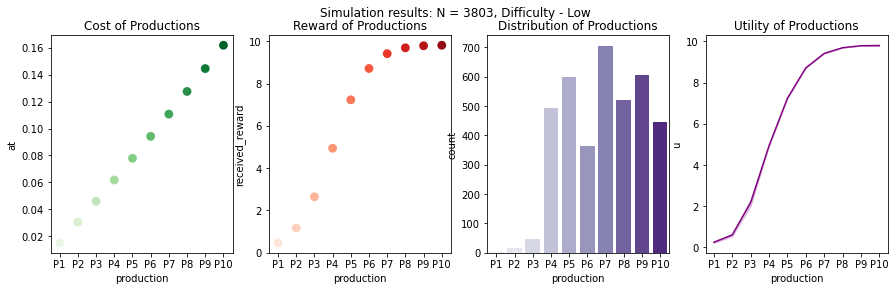

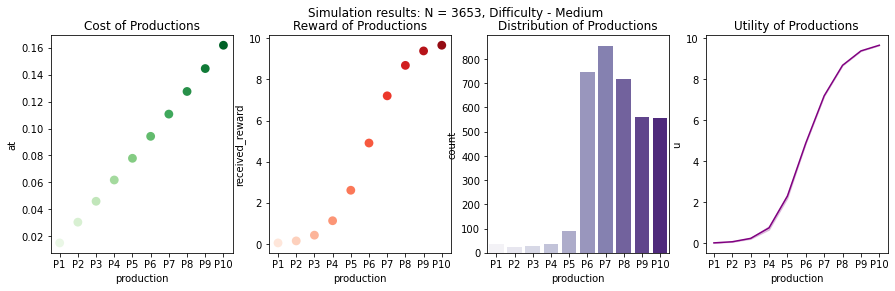

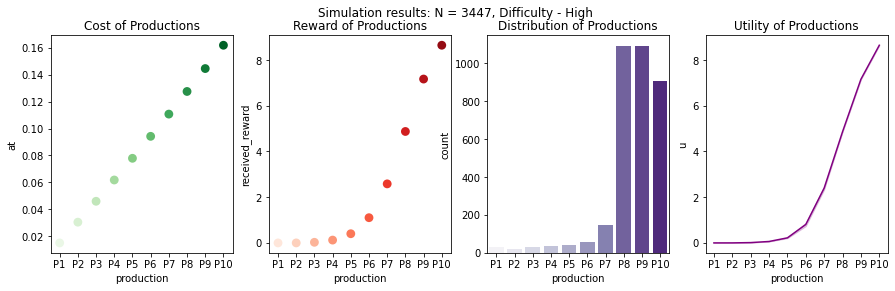

In [10]:
plot_actr_evc1(df1, subtitle="Difficulty - Low")
plot_actr_evc1(df2, subtitle="Difficulty - Medium")
plot_actr_evc1(df3, subtitle="Difficulty - High")

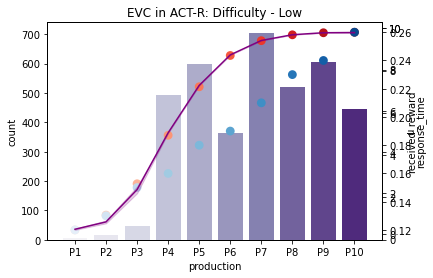

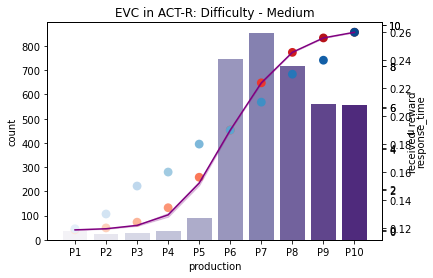

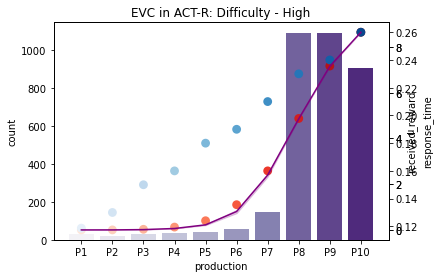

In [11]:
plot_actr_evc2(df1, subtitle="Difficulty - Low")
plot_actr_evc2(df2, subtitle="Difficulty - Medium")
plot_actr_evc2(df3, subtitle="Difficulty - High")

In [12]:
df1[['production', 'response_time']].groupby('production').agg(['mean', 'std'])

response_time     
                    mean  std
production                   
P1                  0.12  0.0
P10                 0.26  0.0
P2                  0.13  0.0
P3                  0.15  0.0
P4                  0.16  0.0
P5                  0.18  0.0
P6                  0.19  0.0
P7                  0.21  0.0
P8                  0.23  0.0
P9                  0.24  0.0

In [13]:
df1[['production', 'delivered_reward', 'received_reward']].groupby('production').agg(['mean', 'std'])

delivered_reward      received_reward     
                       mean  std            mean  std
production                                           
P1                   0.4743  0.0          0.4593  0.0
P10                  9.9753  0.0          9.8133  0.0
P2                   1.1920  0.0          1.1620  0.0
P3                   2.6894  0.0          2.6434  0.0
P4                   5.0000  0.0          4.9380  0.0
P5                   7.3106  0.0          7.2326  0.0
P6                   8.8080  0.0          8.7140  0.0
P7                   9.5257  0.0          9.4147  0.0
P8                   9.8201  0.0          9.6921  0.0
P9                   9.9331  0.0          9.7891  0.0

In [14]:
save = False
suffix = ""#"_retrieval"
todays_date = date.today().strftime("%Y%m%d")
if save:
    curr_dir = os.path.dirname(os.path.realpath('__file__'))
    df1.to_csv(os.path.join(curr_dir, "mini_model_df1{}_{}.txt".format(suffix, todays_date)), index=False)
    df2.to_csv(os.path.join(curr_dir, "mini_model_df2{}_{}.txt".format(suffix, todays_date)), index=False)
    df3.to_csv(os.path.join(curr_dir, "mini_model_df3{}_{}.txt".format(suffix, todays_date)), index=False)
else:
    try:
        df1 = pd.read_csv(os.path.join(curr_dir, "mini_model_df1{}_{}.txt".format(suffix, todays_date)))
        df2 = pd.read_csv(os.path.join(curr_dir, "mini_model_df2{}_{}.txt".format(suffix, todays_date)))
        df3 = pd.read_csv(os.path.join(curr_dir, "mini_model_df3{}_{}.txt".format(suffix, todays_date)))
    except:
        print("No saved data!")

No saved data!


### Some Tests

In [15]:
def cost_function(x, c=1):
    return np.exp(x*c)-1
    #return x**c

def reward_function(x, l=10, k=1, x0=5):
    """
    x0 = middle point
    l = max 
    k = slope
    """
    s = l / (1 + np.exp(-k * ( x - x0)))
    return s

In [16]:
m=MiniModel()
reward = np.arange(10)
reward_trans = [reward_function(r, l=10, k=1, x0=5) for r in reward]

cost = np.arange(10)/100
cost_trans = [cost_function(x, c=1.5) for x in cost]
cost_trans

[0.0,
 0.01511306461571893,
 0.030454533953516938,
 0.04602785990871694,
 0.06183654654535964,
 0.07788415088463152,
 0.09417428370521042,
 0.11071061035570517,
 0.12749685157937574,
 0.14453678435131456]

(-0.0, 9.9)

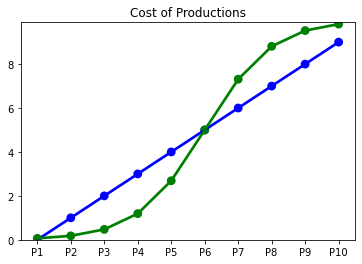

In [17]:
ax=sns.pointplot(x=m.ordered_productions, y=reward, color="blue", join=True, order=m.ordered_productions).set_title('Cost of Productions')
ax=sns.pointplot(x=m.ordered_productions, y=reward_trans, color="green", join=True, order=m.ordered_productions).set_title('Cost of Productions')
plt.ylim(min(reward)*-1.1, max(reward)*1.1)

(-0.0, 0.15899046278644602)

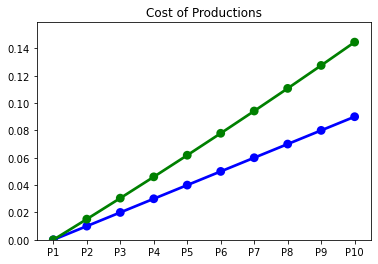

In [18]:
ax=sns.pointplot(x=m.ordered_productions, y=cost, color="blue", order=m.ordered_productions).set_title('Cost of Productions')
ax=sns.pointplot(x=m.ordered_productions, y=cost_trans, color="green", order=m.ordered_productions).set_title('Cost of Productions')
plt.ylim(min(cost)*-1.1, max(cost_trans)*1.1)